# Titanic Survival Prediction: A Classification Model Approach

## Import Required Libraries

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

## Adjusting Row Column Settings

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)

## Load Dataset

In [8]:
df = sns.load_dataset("titanic")

In [9]:
df.columns = [col.upper() for col in df.columns]

df.head()

,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,CLASS,WHO,ADULT_MALE,DECK,EMBARK_TOWN,ALIVE,ALONE
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


## Overview

In [10]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    
check_df(df)

##################### Shape #####################
(891, 15)
##################### Types #####################
SURVIVED          int64
PCLASS            int64
SEX              object
AGE             float64
SIBSP             int64
PARCH             int64
FARE            float64
EMBARKED         object
CLASS          category
WHO              object
ADULT_MALE         bool
DECK           category
EMBARK_TOWN      object
ALIVE            object
ALONE              bool
dtype: object
##################### Duplicated Values #####################
107
##################### Missing Values #####################
SURVIVED         0
PCLASS           0
SEX              0
AGE            177
SIBSP            0
PARCH            0
FARE             0
EMBARKED         2
CLASS            0
WHO              0
ADULT_MALE       0
DECK           688
EMBARK_TOWN      2
ALIVE            0
ALONE            0
dtype: int64


In [11]:
duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()
print(df.duplicated().sum())


0


In [12]:
print("##################### Quantiles #####################")
print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

##################### Quantiles #####################
           count   mean    std   min    0%    5%    50%     95%     99%    100%     max
SURVIVED 784.000  0.412  0.493 0.000 0.000 0.000  0.000   1.000   1.000   1.000   1.000
PCLASS   784.000  2.244  0.855 1.000 1.000 1.000  3.000   3.000   3.000   3.000   3.000
AGE      678.000 29.869 14.759 0.420 0.420 4.000 28.250  57.000  66.920  80.000  80.000
SIBSP    784.000  0.523  0.986 0.000 0.000 0.000  0.000   2.000   4.000   8.000   8.000
PARCH    784.000  0.416  0.837 0.000 0.000 0.000  0.000   2.000   4.000   6.000   6.000
FARE     784.000 34.712 52.160 0.000 0.000 7.225 15.900 120.000 262.375 512.329 512.329


In [43]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    
    return cat_cols, num_cols, cat_but_car


grab_col_names(df)


Observations: 784
Variables: 15
cat_cols: 13
num_cols: 2
cat_but_car: 0
num_but_cat: 8


(['SEX',
  'EMBARKED',
  'WHO',
  'EMBARK_TOWN',
  'ALIVE',
  'SURVIVED',
  'PCLASS',
  'SIBSP',
  'PARCH',
  'CLASS',
  'ADULT_MALE',
  'DECK',
  'ALONE'],
 ['AGE', 'FARE'],
 [])

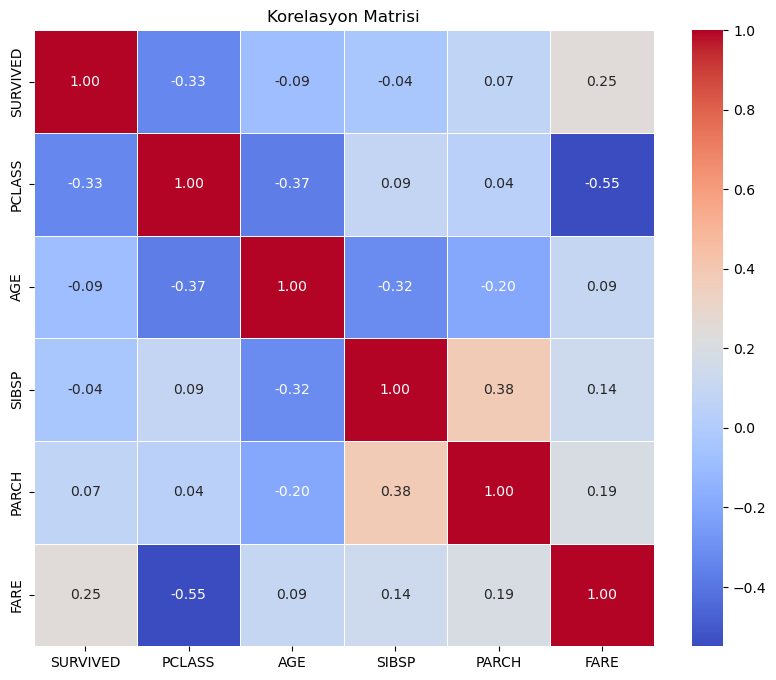

In [14]:
numeric_df = df.select_dtypes(include=[float, int])

corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasyon Matrisi')
plt.show()


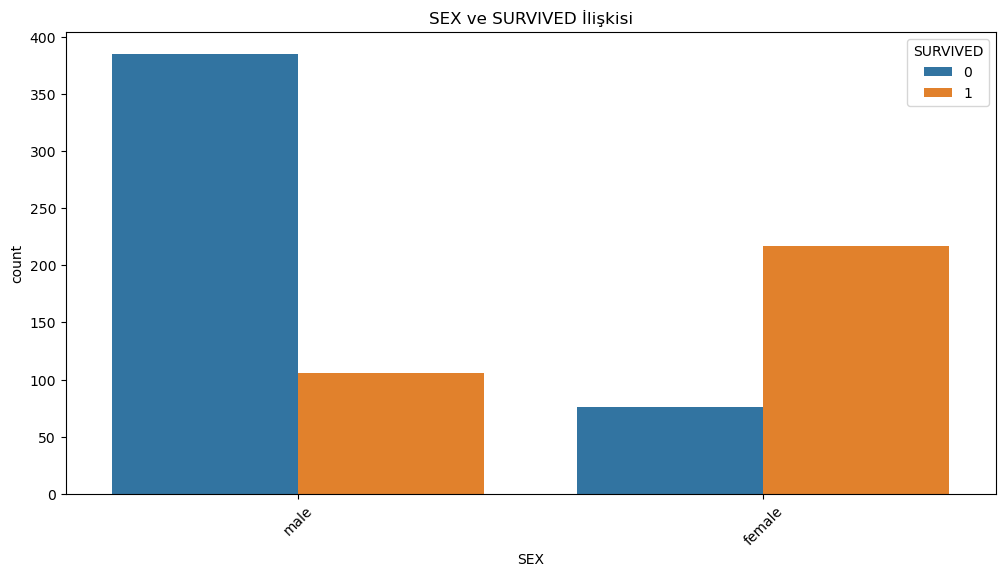

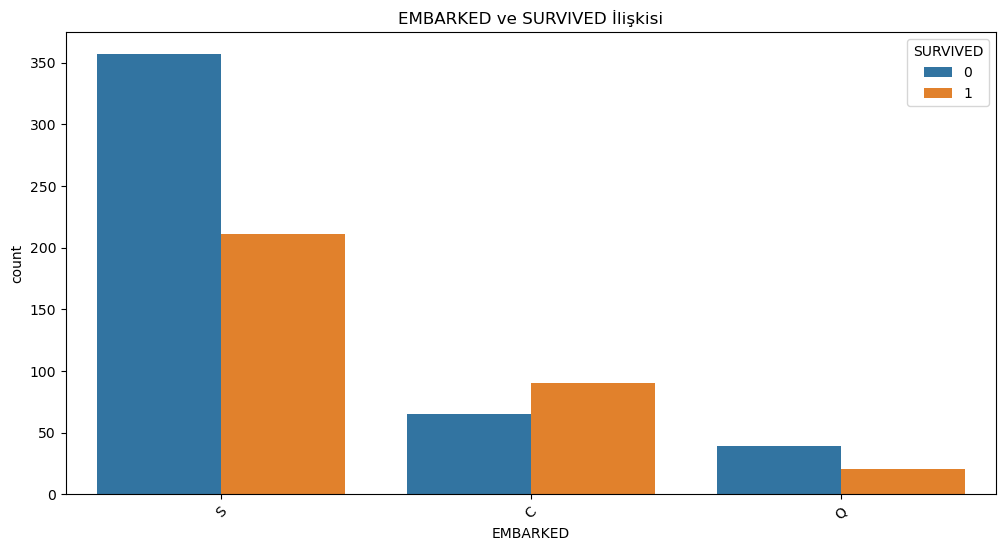

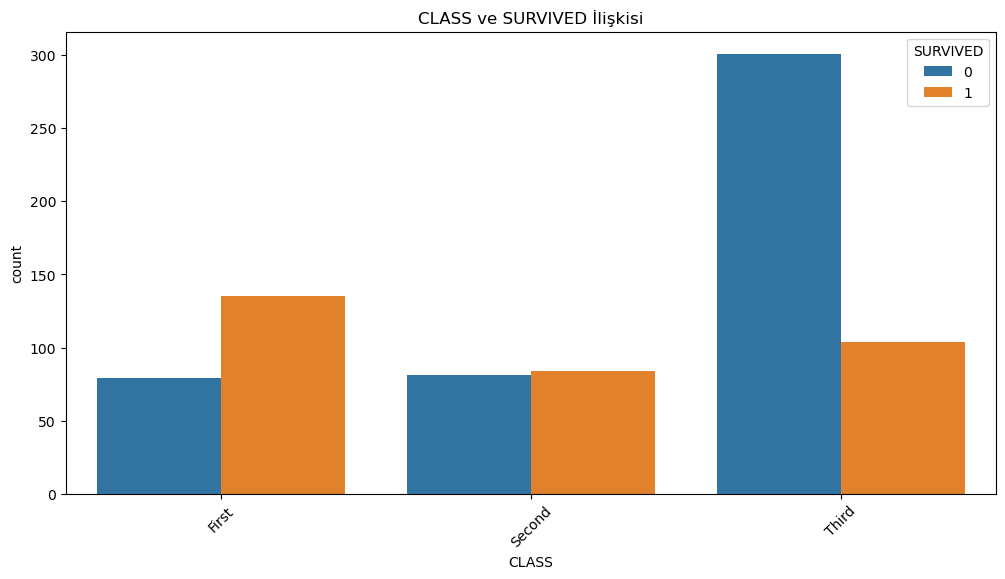

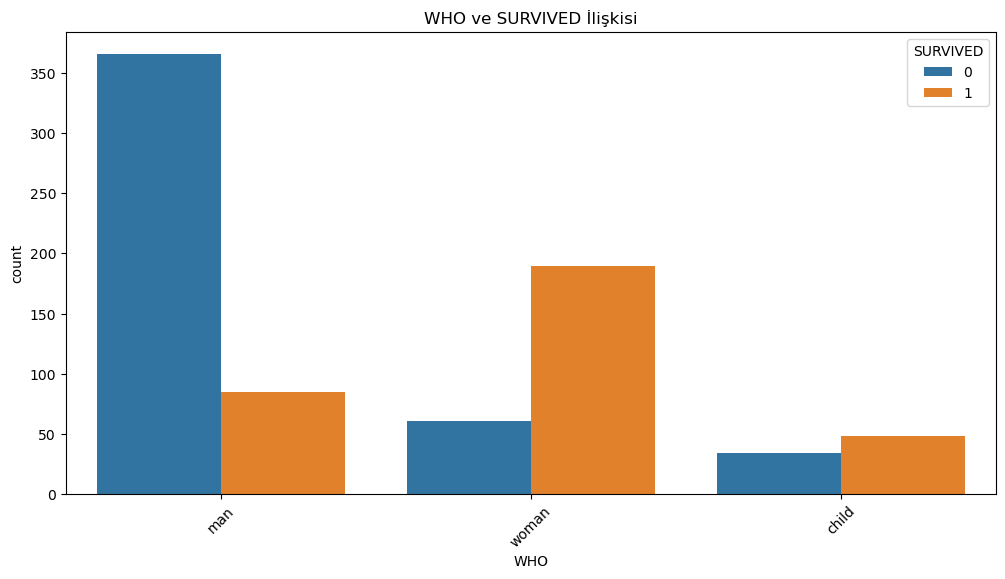

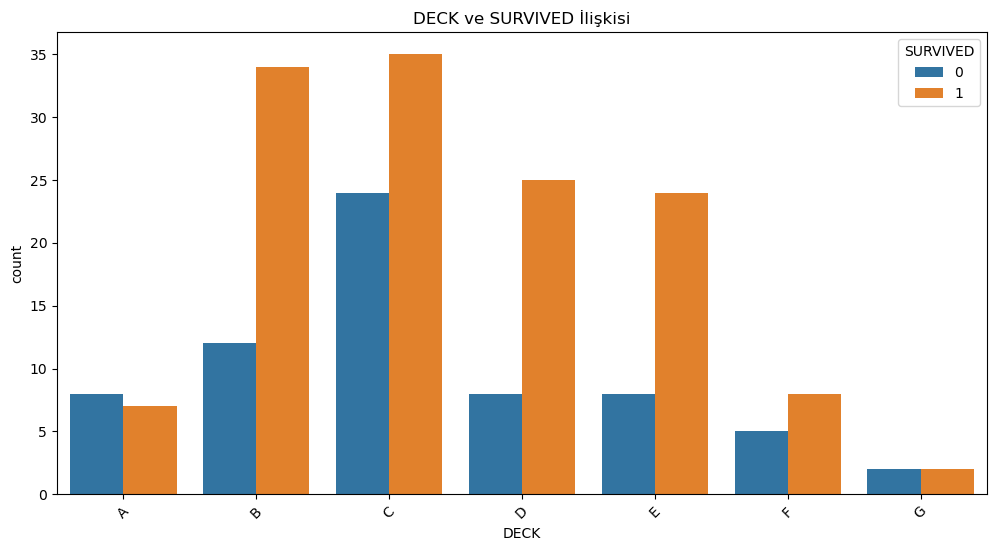

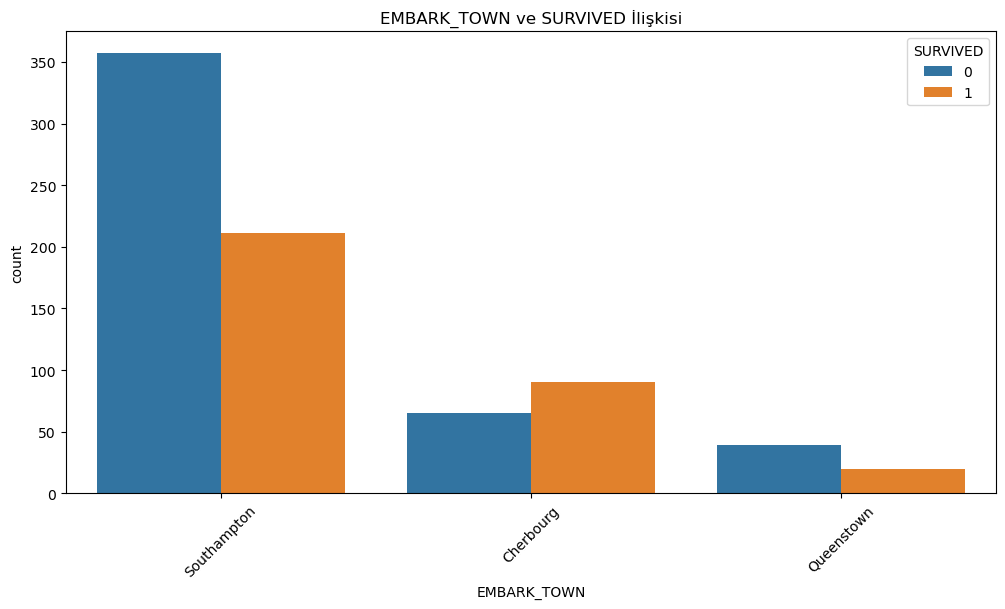

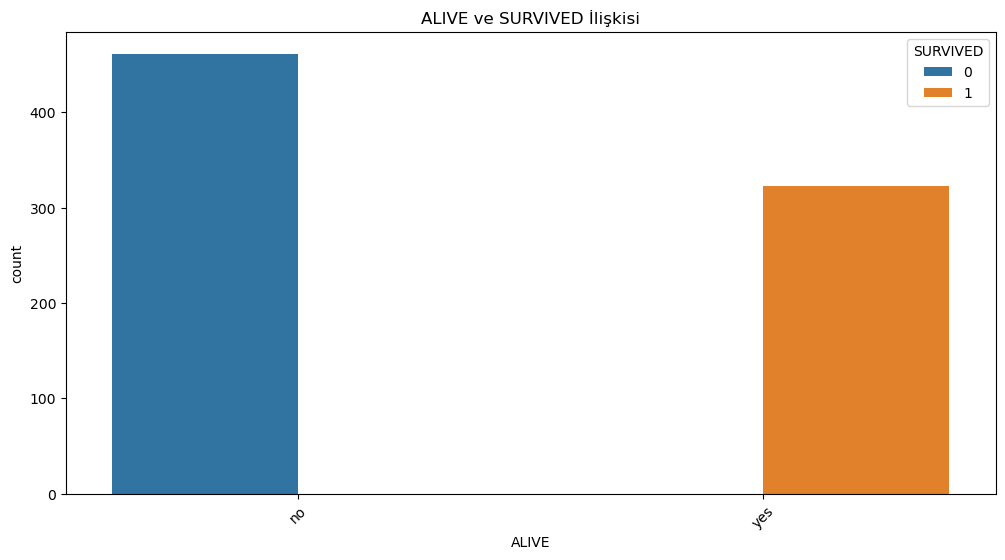

In [15]:
def plot_categorical_relationships(df, target):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        plt.figure(figsize=(12, 6))
        sns.countplot(x=col, hue=target, data=df)
        plt.title(f'{col} ve {target} İlişkisi')
        plt.xticks(rotation=45)  
        plt.show()
        
plot_categorical_relationships(df, 'SURVIVED')

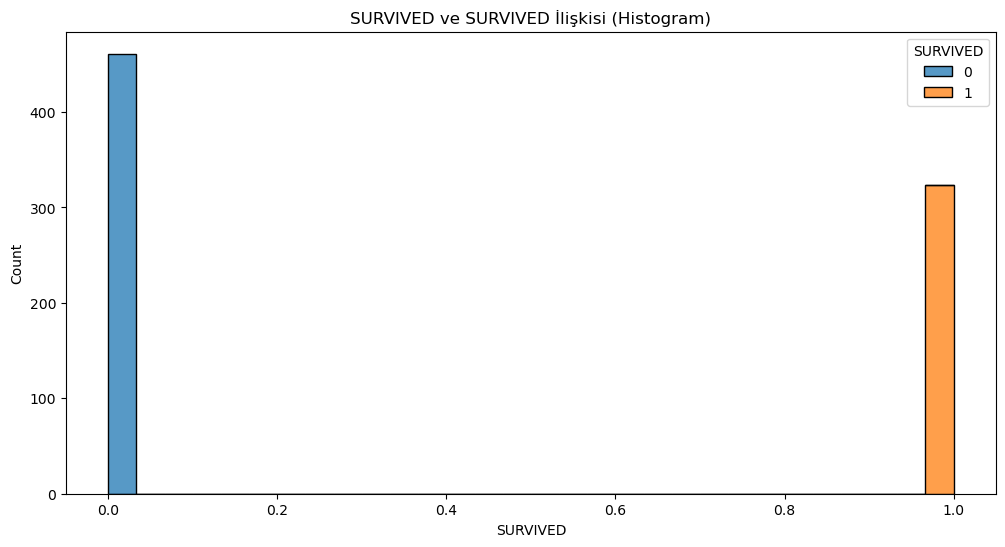

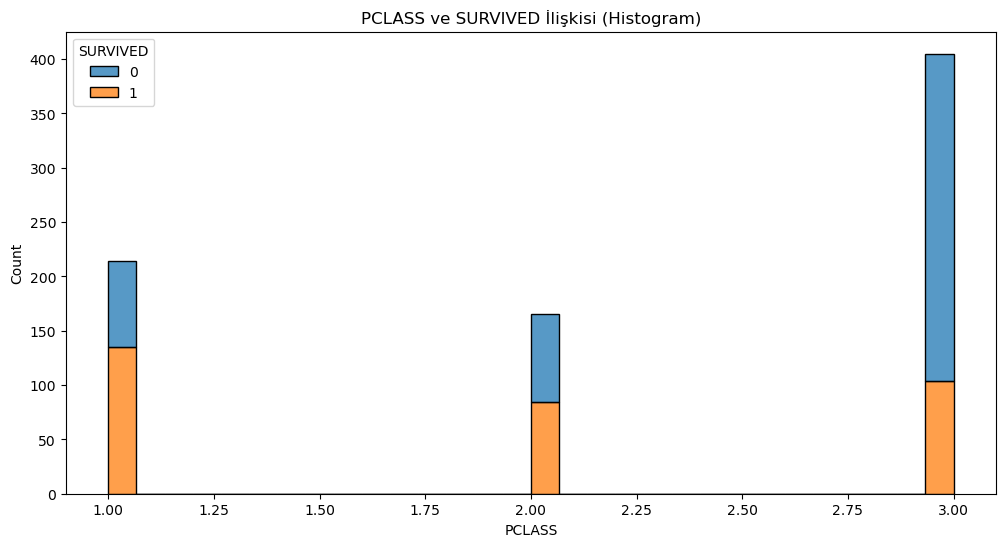

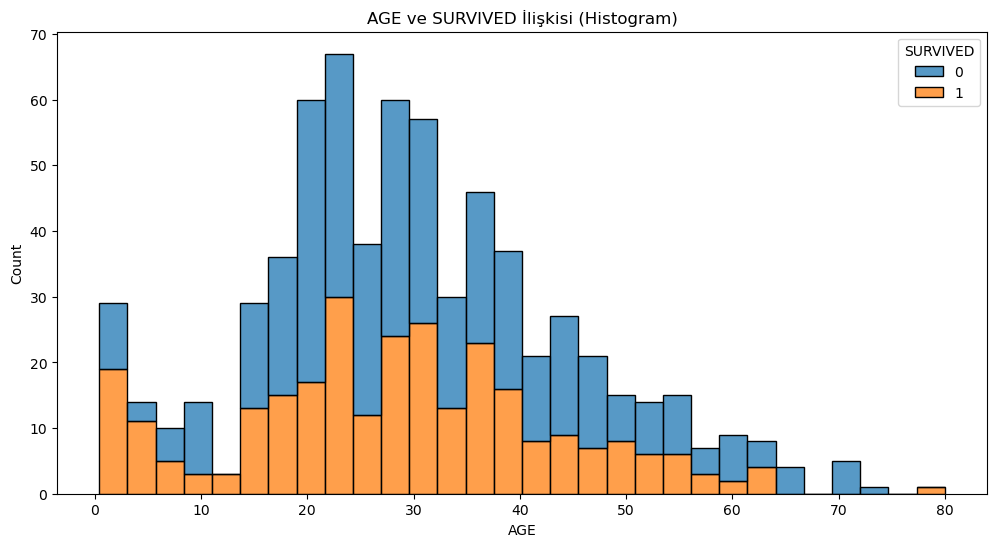

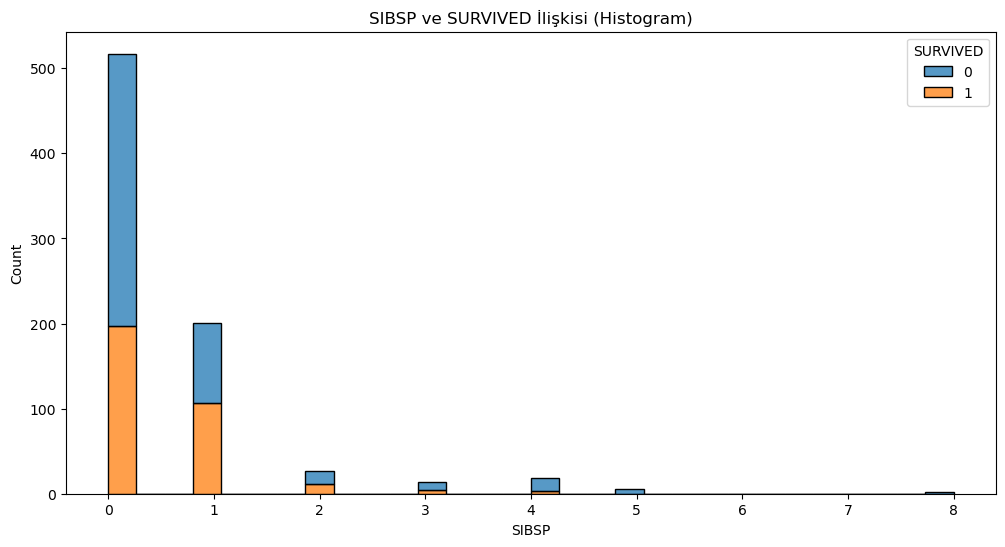

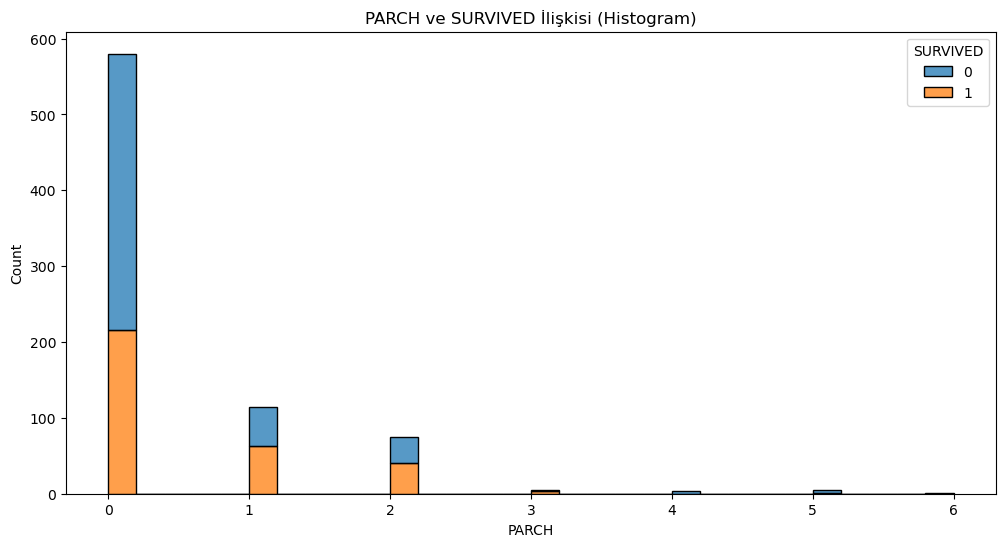

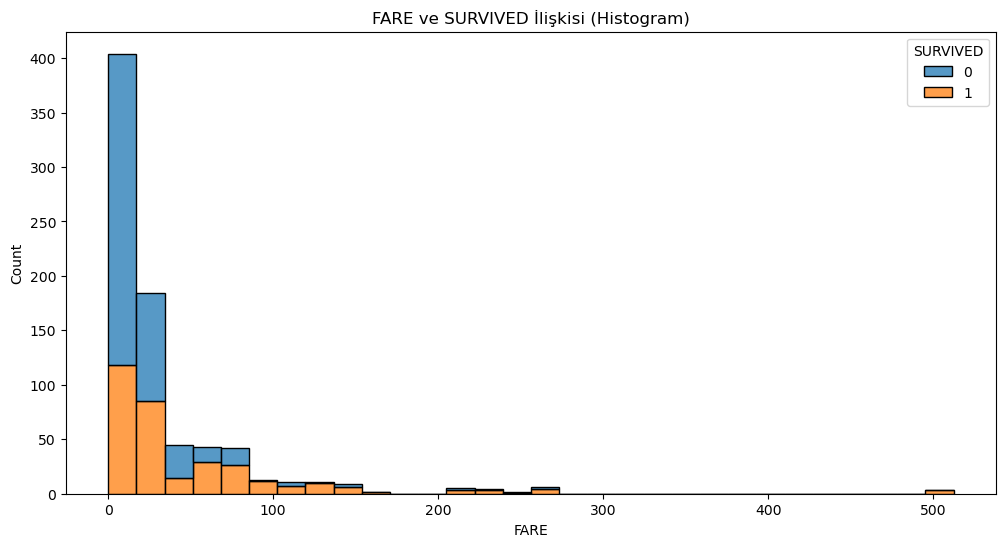

In [16]:
def plot_numerical_relationships(df, target):
    
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    for col in numerical_cols:
        # Dağılım grafiği (histogram) ve hedef değişkenle ilişkisini göster
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x=col, hue=target, multiple='stack', bins=30)
        plt.title(f'{col} ve {target} İlişkisi (Histogram)')
        plt.show()
        
plot_numerical_relationships(df, 'SURVIVED')

## Preprocessing

### Missing Values

In [17]:
#Age eksik değerlerin doldurulması

child_age_mean = df[df['WHO'] == 'child']['AGE'].mean()
man_age_mean = df[df['WHO'] == 'man']['AGE'].mean()
woman_age_mean = df[df['WHO'] == 'woman']['AGE'].mean()

df.loc[(df['WHO'] == 'child') & (df['AGE'].isnull()), 'AGE'] = child_age_mean
df.loc[(df['WHO'] == 'man') & (df['AGE'].isnull()), 'AGE'] = man_age_mean
df.loc[(df['WHO'] == 'woman') & (df['AGE'].isnull()), 'AGE'] = woman_age_mean

#Deck eksik değerlerinin doldurulması

def fill_missing_decks(df):
    
    # 1. Sınıf yolcular için güverte tahmini
    df.loc[(df['DECK'].isnull()) & (df['PCLASS'] == 1), 'DECK'] = 'C'  
    
    # 2. Sınıf yolcular için güverte tahmini
    df.loc[(df['DECK'].isnull()) & (df['PCLASS'] == 2), 'DECK'] = 'D' 
    
    # 3. Sınıf yolcular için güverte tahmini
    df.loc[(df['DECK'].isnull()) & (df['PCLASS'] == 3), 'DECK'] = 'F'  
    
    return df

df = fill_missing_decks(df)

#Embarked eksik değerlerinin doldurulması

most_common_embarked = df['EMBARKED'].mode()[0]
df['EMBARKED'].fillna(most_common_embarked, inplace=True)

#Embark_town eksik değerlerinin doldurulması

most_common_town = df['EMBARK_TOWN'].mode()[0]
df['EMBARK_TOWN'].fillna(most_common_town, inplace=True)

print(df.isnull().sum())

SURVIVED       0
PCLASS         0
SEX            0
AGE            0
SIBSP          0
PARCH          0
FARE           0
EMBARKED       0
CLASS          0
WHO            0
ADULT_MALE     0
DECK           0
EMBARK_TOWN    0
ALIVE          0
ALONE          0
dtype: int64


## Feature Engineering

In [53]:
# Age_Pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

#Family Size
df['FAMILYSIZE'] = df['SIBSP'] + df['PARCH'] + 1
df['ISALONE'] = df['FAMILYSIZE'].apply(lambda x: 1 if x == 1 else 0)

#Fare Bins
df['FAREBIN'] = pd.qcut(df['FARE'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])

df.head()

,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,CLASS,WHO,ADULT_MALE,DECK,EMBARK_TOWN,ALIVE,ALONE,NEW_AGE_PCLASS,FAMILYSIZE,ISALONE,FAREBIN
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,F,Southampton,no,False,66.000,2,0,Low
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False,38.000,2,0,VeryHigh
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,F,Southampton,yes,True,78.000,1,1,Low
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False,35.000,2,0,VeryHigh
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,F,Southampton,no,True,105.000,1,1,Low


## One-Hot Encoding

In [72]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

df.head()

,SURVIVED,SEX,AGE,FARE,ADULT_MALE,ALIVE,ALONE,NEW_AGE_PCLASS,ISALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_0,EMBARKED_1,EMBARKED_2,CLASS_First,CLASS_Second,CLASS_Third,WHO_0,WHO_1,WHO_2,DECK_A,DECK_B,DECK_C,DECK_D,DECK_E,DECK_F,DECK_G,EMBARK_TOWN_0,EMBARK_TOWN_1,EMBARK_TOWN_2,FAMILYSIZE_1,FAMILYSIZE_2,FAMILYSIZE_3,FAMILYSIZE_4,FAMILYSIZE_5,FAMILYSIZE_6,FAMILYSIZE_7,FAMILYSIZE_8,FAMILYSIZE_11,FAREBIN_Low,FAREBIN_Medium,FAREBIN_High,FAREBIN_VeryHigh
0,0,1,-0.604,-0.527,1,0,0,66.000,0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False
1,1,0,0.559,0.702,0,1,0,38.000,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
2,1,0,-0.313,-0.514,0,1,1,78.000,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False
3,1,0,0.341,0.353,0,1,0,35.000,0,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True
4,0,1,0.341,-0.511,1,0,1,105.000,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False


## Standard Scaler

In [63]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head

<bound method NDFrame.head of        AGE   FARE
0   -0.604 -0.527
1    0.559  0.702
2   -0.313 -0.514
3    0.341  0.353
4    0.341 -0.511
5    0.247 -0.504
6    1.721  0.329
7   -2.057 -0.262
8   -0.240 -0.452
9   -1.185 -0.089
10  -1.911 -0.346
11   2.012 -0.157
12  -0.749 -0.511
13   0.632 -0.066
14  -1.185 -0.515
15   1.794 -0.359
16  -2.057 -0.107
17   0.247 -0.417
18   0.050 -0.321
19   0.122 -0.527
20   0.341 -0.167
21   0.268 -0.417
22  -1.112 -0.512
23  -0.168  0.015
24  -1.621 -0.262
25   0.559 -0.064
26   0.247 -0.527
27  -0.822  4.379
28   0.122 -0.515
29   0.247 -0.514
30   0.704 -0.134
31   0.122  2.145
32   0.122 -0.517
33   2.593 -0.464
34  -0.168  0.910
35   0.850  0.332
36   0.247 -0.527
37  -0.676 -0.511
38  -0.894 -0.321
39  -1.185 -0.450
40   0.704 -0.484
41  -0.240 -0.263
42   0.247 -0.514
43  -1.984  0.132
44  -0.822 -0.515
45   0.247 -0.511
46   0.247 -0.369
48   0.247 -0.250
49  -0.894 -0.324
50  -1.693  0.095
51  -0.676 -0.516
52   1.358  0.806
53  -0.095 -0.16

## Model

In [83]:
X = df.drop(['SURVIVED','ALIVE'], axis=1)
y = df["SURVIVED"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

rf_model = RandomForestClassifier(random_state=19).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

def evaluate_model(model, X_test, y_test, y_pred):
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
evaluate_model(rf_model, X_test, y_test, y_pred)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ROC AUC Score: 0.8534
F1 Score: 0.7442
Recall: 0.7869
Precision: 0.7059
Accuracy: 0.7898

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        96
           1       0.71      0.79      0.74        61

    accuracy                           0.79       157
   macro avg       0.78      0.79      0.78       157
weighted avg       0.80      0.79      0.79       157



In [85]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

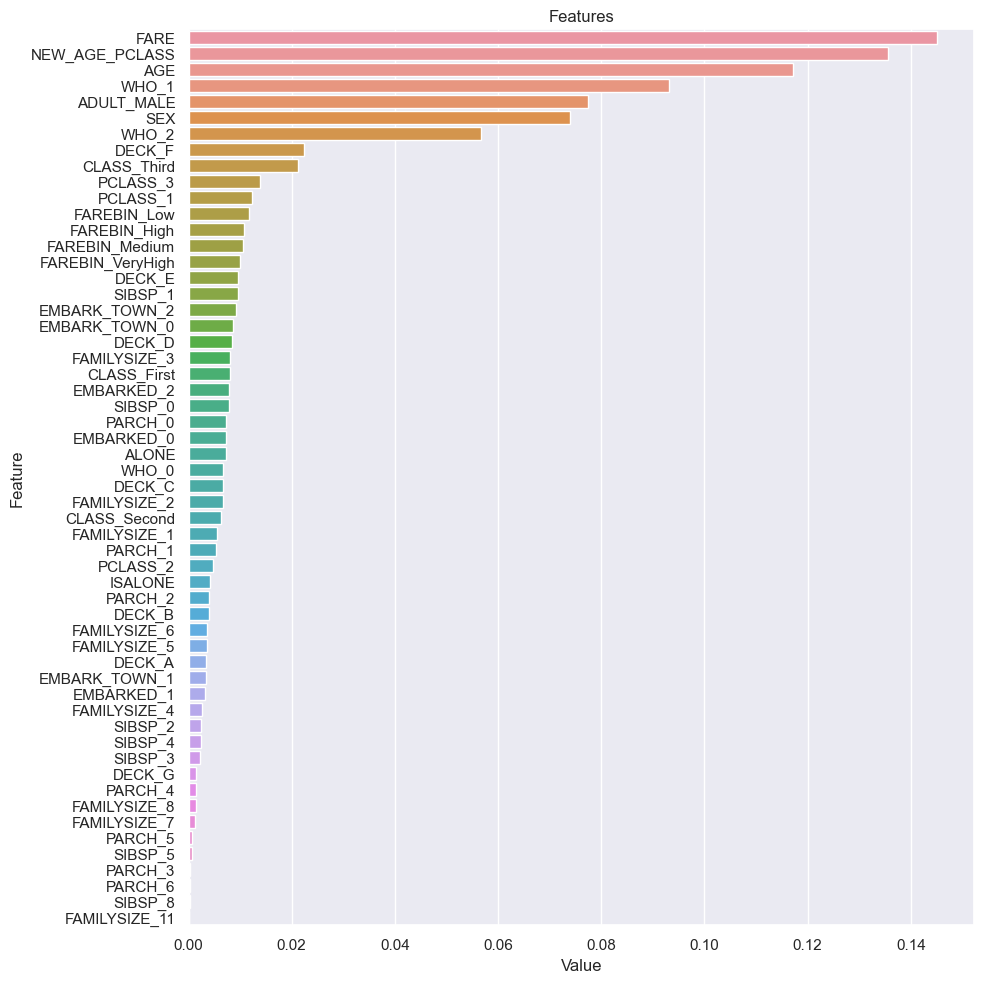

In [86]:
plot_importance(rf_model, X_train, X)